# Mathematical model
### List
$$ S = Students, \ C = Class $$
$$ S_{male} = male, \ S_{female} = female $$
$$ S_{leader} = leader, \ S_{support} = support $$
$$ S_{specific} = specific_pair $$
### Variable
$$ x_{s, c} \in \{0, 1\} \quad (s \in S, c \in C) $$
### Constant
$$ S_{score} = student\_score $$
$$ score\_mean = student\_score\_mean $$

### 制約式
- クラスに必ず割り当てる
$$ \sum_{c\in C} x_{s, c} = 1 \quad (s\in S) $$
- クラス人数
$$ \sum_{s\in S} x_{s, c} \ge 39, \ \sum_{s\in S} x_{s, c} \le 40 \quad (c\in C) $$
- 男女人数
$$ \sum_{s\in S_{male}} x_{s, c} \le 20, \ \sum_{s\in S_{female}} x_{s, c} \le 20 \quad (c\in C) $$
- リーダーとサポート人数
$$ \sum_{s\in S_{leader}} x_{s, c} \ge 2, \ \sum_{s\in S_{support}} x_{s, c} \le 1 \quad (c\in C) $$
- 全体平均との差異
$$ score mean - 10 <= \frac{\sum_{s\in S}x_{s, c} \times score_s}{\sum_{s\in S}x_{s, c}} $$
$$ score mean + 10 <= \frac{\sum_{s\in S}x_{s, c} \times score_s}{\sum_{s\in S}x_{s, c}} $$
$$  $$


In [1]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
from itertools import product

In [2]:
students_df = pd.read_csv(glob('../*/*school/students.csv')[0])
student_pairs_df = pd.read_csv(glob('../*/*school/student_pairs.csv')[0])
display(students_df.head(3))
student_pairs_df.head(3)

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350


,student_id1,student_id2
0,118,189
1,72,50
2,314,233


In [3]:
MAX_STUDENT_NUM = 40
S = students_df['student_id'].to_list()
S
class_num = math.ceil(students_df['student_id'].count() / MAX_STUDENT_NUM)
C = [chr(65+i) for i in range(class_num)]
C
S_male = students_df['student_id'][students_df['gender'] == 1].to_list()
S_male
S_female = students_df['student_id'][students_df['gender'] == 0].to_list()
S_female
S_leader = students_df['student_id'][students_df['leader_flag'] == 1].to_list()
S_leader
S_support = students_df['student_id'][students_df['support_flag'] == 1].to_list()
S_support
S_specific = [(row.student_id1, row.student_id2) for row in student_pairs_df.itertuples()]
S_specific
score_mean = students_df['score'].mean()
score_mean
S_score = {row.student_id: row.score for row in students_df.itertuples()}
SC = [(s, c) for s in S for c in C]
SC

students_df['rank'] = students_df['score'].rank(ascending=False, method='first')
class_dict = {i:c for i, c in enumerate(C)}
students_df['init_class'] = students_df['rank'].map(lambda x: x % 8).map(class_dict)

init_flag = {(s, c): 0 for s in S for c in C}
for row in students_df.itertuples():
    init_flag[row.student_id, row.init_class] = 1
init_flag

x = LpVariable.dicts('x', SC, cat='Binary')

In [4]:
m = LpProblem('class', sense=LpMaximize)

m += lpSum([x[s, c] * init_flag[s, c] for s, c in SC])

for s in S:
    m += lpSum(x[s, c] for c in C) == 1

for c in C:
    m += lpSum(x[s, c] for s in S) >= 39
    m += lpSum(x[s, c] for s in S) <= 40

    m += lpSum(x[s, c] for s in S_male) <= 20
    m += lpSum(x[s, c] for s in S_female) <= 20

    m += lpSum(x[s, c] for s in S_leader) >= 2
    m += lpSum(x[s, c] for s in S_support) <= 1

    m += (score_mean - 10) * lpSum(x[s, c] for s in S) <= lpSum(x[s, c] * S_score[s] for s in S)
    m += (score_mean + 10) * lpSum(x[s, c] for s in S) >= lpSum(x[s, c] * S_score[s] for s in S)

for s1, s2 in S_specific:
    for c in C:
        m += x[s1, c] + x[s2, c] <= 1

status = m.solve()
print(LpStatus[status])

Optimal


In [5]:
class_organization = {}
for c in C:
    student_id_list = [s for s in S if x[s, c].value() == 1]
    class_organization[c] = student_id_list
    print(c, len(student_id_list), student_id_list)

A 40 [2, 23, 56, 68, 76, 82, 89, 102, 106, 113, 115, 121, 123, 124, 127, 140, 172, 173, 185, 186, 204, 210, 228, 255, 267, 273, 274, 280, 285, 288, 289, 292, 295, 297, 304, 308, 311, 313, 316, 318]
B 39 [11, 14, 17, 30, 32, 35, 41, 49, 64, 66, 79, 83, 86, 88, 97, 114, 119, 122, 132, 134, 141, 149, 151, 165, 175, 178, 190, 198, 200, 209, 213, 216, 226, 237, 272, 296, 303, 306, 307]
C 40 [21, 38, 44, 46, 51, 54, 62, 63, 73, 75, 84, 85, 99, 120, 138, 142, 143, 144, 150, 166, 183, 184, 192, 193, 195, 201, 205, 207, 211, 212, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]
D 40 [5, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 109, 116, 131, 136, 147, 152, 155, 167, 169, 170, 176, 177, 196, 199, 214, 218, 219, 227, 230, 231, 236, 238, 239, 253, 257, 259, 271, 309]
E 39 [4, 8, 12, 13, 19, 22, 33, 43, 48, 55, 57, 59, 98, 112, 125, 130, 133, 137, 139, 153, 160, 189, 203, 234, 235, 240, 241, 249, 251, 254, 256, 261, 266, 268, 276, 283, 291, 294, 302]
F 40 [1, 6, 16, 27, 28, 29, 40, 42, 45, 58,

In [6]:
result_df = students_df.copy()
S2C = {s: c for s in S for c in C if x[s, c].value() == 1}
result_df['class'] = result_df['student_id'].map(S2C)
result_df.head(3)

,student_id,gender,leader_flag,support_flag,score,rank,init_class,class
0,1,0,0,0,335,109.0,F,F
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,H


In [7]:
result_df.groupby('class').count()
result_df.groupby(['class', 'gender']).count()
result_df.groupby(['class', 'leader_flag']).count()
result_df.groupby(['class', 'support_flag']).count()
result_df.groupby(['class']).mean(numeric_only=True) - score_mean
for s1, s2 in S_specific:
    print(f'{S2C[s1]==S2C[s2]}: ', f'id {s1:03} class {S2C[s1]} and id {s2:03} class {S2C[s2]}')

False:  id 118 class F and id 189 class E
False:  id 072 class H and id 050 class D
False:  id 314 class G and id 233 class H


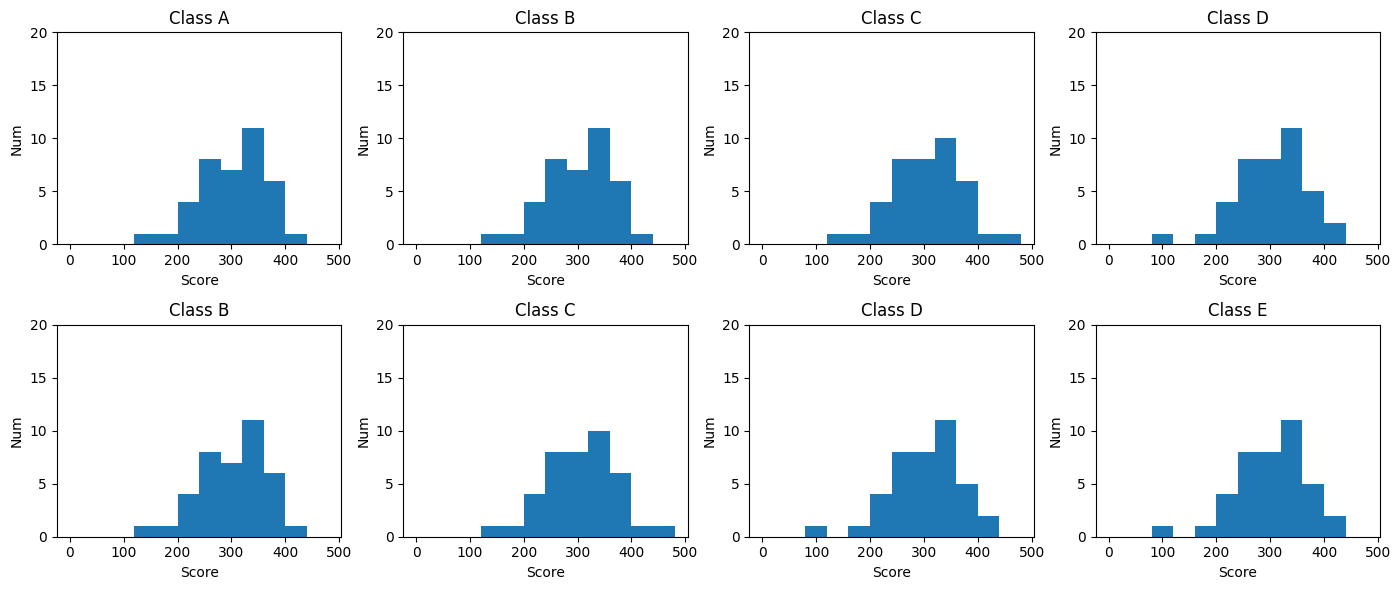

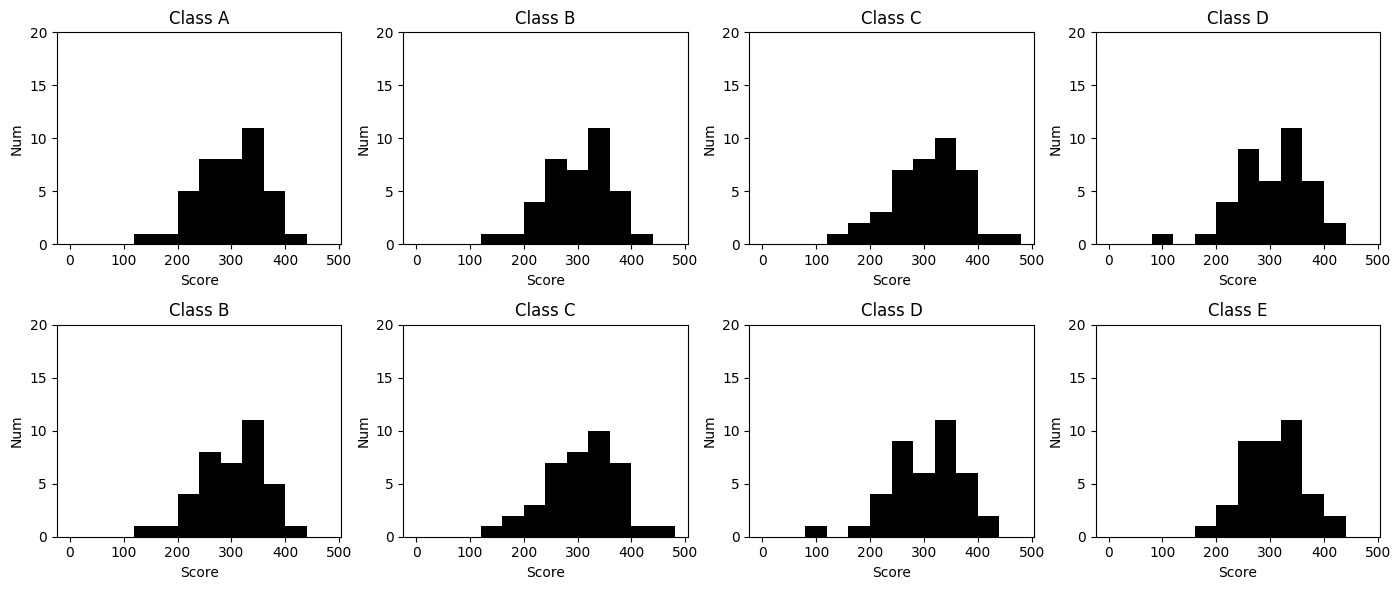

In [8]:
nrows, ncols = 2, 4

fig, axs1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6))
for i in range(nrows):
    for j in range(ncols):
        class_ = chr(65+i+j)
        class_score = students_df['score'][students_df['init_class'] == class_]
        axs1[i][j].hist(class_score, bins=range(0, 500, 40))
        axs1[i][j].set_ylim(0, 20)
        axs1[i][j].set_xlabel('Score')
        axs1[i][j].set_ylabel('Num')
        axs1[i][j].set_title(f'Class {class_}')
plt.tight_layout()
plt.show()

fig, axs2 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6))
for i in range(nrows):
    for j in range(ncols):
        class_ = chr(65+i+j)
        class_score = result_df['score'][result_df['class'] == class_]
        axs2[i][j].hist(class_score, bins=range(0, 500, 40), color='k')
        axs2[i][j].set_ylim(0, 20)
        axs2[i][j].set_xlabel('Score')
        axs2[i][j].set_ylabel('Num')
        axs2[i][j].set_title(f'Class {class_}')
plt.tight_layout()
plt.show()

In [9]:
class_organization = {}
for c in C:
    student_id_list = [s for s in S if x[s, c].value() == 1]
    class_organization[c] = student_id_list
    print(c, len(student_id_list), student_id_list)

A 40 [2, 23, 56, 68, 76, 82, 89, 102, 106, 113, 115, 121, 123, 124, 127, 140, 172, 173, 185, 186, 204, 210, 228, 255, 267, 273, 274, 280, 285, 288, 289, 292, 295, 297, 304, 308, 311, 313, 316, 318]
B 39 [11, 14, 17, 30, 32, 35, 41, 49, 64, 66, 79, 83, 86, 88, 97, 114, 119, 122, 132, 134, 141, 149, 151, 165, 175, 178, 190, 198, 200, 209, 213, 216, 226, 237, 272, 296, 303, 306, 307]
C 40 [21, 38, 44, 46, 51, 54, 62, 63, 73, 75, 84, 85, 99, 120, 138, 142, 143, 144, 150, 166, 183, 184, 192, 193, 195, 201, 205, 207, 211, 212, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]
D 40 [5, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 109, 116, 131, 136, 147, 152, 155, 167, 169, 170, 176, 177, 196, 199, 214, 218, 219, 227, 230, 231, 236, 238, 239, 253, 257, 259, 271, 309]
E 39 [4, 8, 12, 13, 19, 22, 33, 43, 48, 55, 57, 59, 98, 112, 125, 130, 133, 137, 139, 153, 160, 189, 203, 234, 235, 240, 241, 249, 251, 254, 256, 261, 266, 268, 276, 283, 291, 294, 302]
F 40 [1, 6, 16, 27, 28, 29, 40, 42, 45, 58,